In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import stats
import seaborn as sns

# 2. Preprocessing, Feature Engineering and Exploratory Data Analysis

In [ ]:
df = pd.read_excel('merged.xlsx')
df.dropna(axis=1, inplace=True)
print(df.columns.values)

In [47]:
df['win_%'] = df['total_matches_won'] / df['total_matches_played']
df["kd"] = df['total_kills'] / df['total_deaths']
df["hs_%"] = df['total_kills_headshot'] / df['total_kills']
df["accuracy"] = df['total_shots_hit'] / df['total_shots_fired']
df["mvp_%"] = df["total_mvps"] / df['total_rounds_played']
df["dmg_round"] = df["total_damage_done"] / df['total_rounds_played']
df["contribution_round"] = df["total_contribution_score"] / df['total_rounds_played']
df = df.rename(columns={'Banned': 'banned'})
columns = ['win_%',"hs_%","mvp_%","kd","dmg_round","accuracy","contribution_round","total_matches_played","banned"]
df = df[columns].copy()

# Saving final dataframe for EDA and ML training
df.to_excel("players_stats.xlsx",index=False) 

In [10]:
#After manual evaluation and cleaning of extreme/incorrect values 
df = pd.read_excel('players_stats.xlsx')
del df['total_matches_played']
n_df = df.drop("banned", axis=1)
n_df = np.log1p(n_df)
n_df = pd.concat([n_df, df["banned"]], axis=1)

# Natural means
dfa = df.groupby('banned').mean()
display(dfa)

# Normalized Means
n_dfa = n_df.groupby('banned').mean()
n_dfa

,win_%,hs_%,mvp_%,kd,dmg_round,accuracy,contribution_round
banned,,,,,,,
0,0.435083,0.427732,0.135698,1.108721,189.428800,0.197866,4.435958
1,0.452914,3.880293,0.164403,33.324899,261.833686,0.223949,4.772626


,win_%,hs_%,mvp_%,kd,dmg_round,accuracy,contribution_round
banned,,,,,,,
0,0.361223,0.356087,0.127247,0.746082,5.249278,0.180541,1.693036
1,0.373571,1.585205,0.152208,3.535871,5.571521,0.202082,1.753127


## Correlation matrix

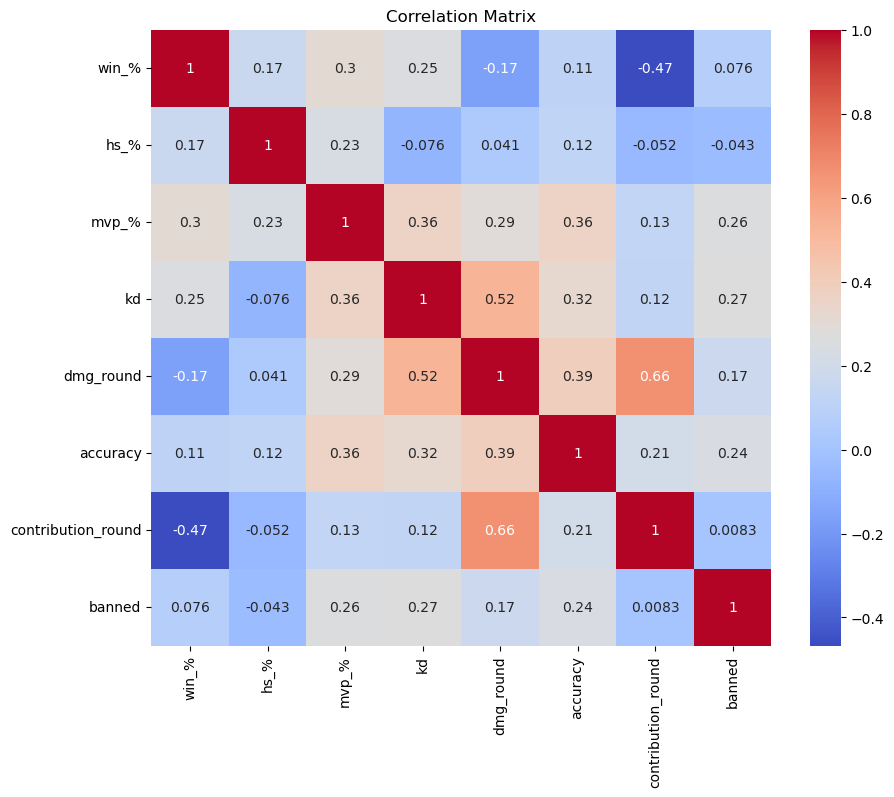

In [4]:
corr_matrix = n_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Feature Density

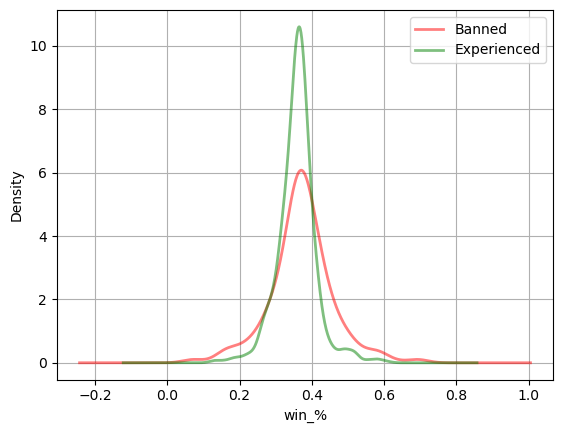

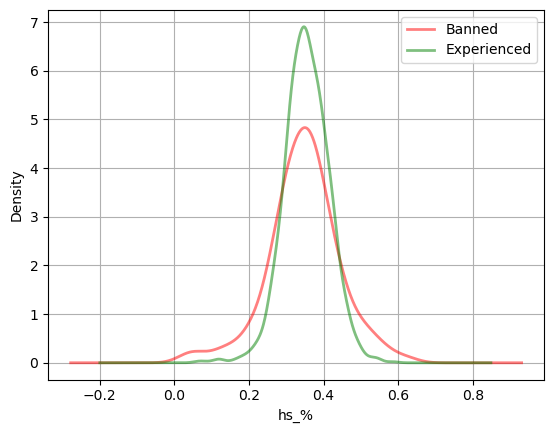

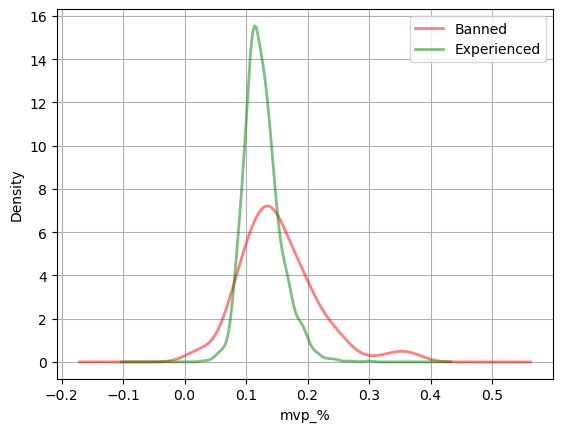

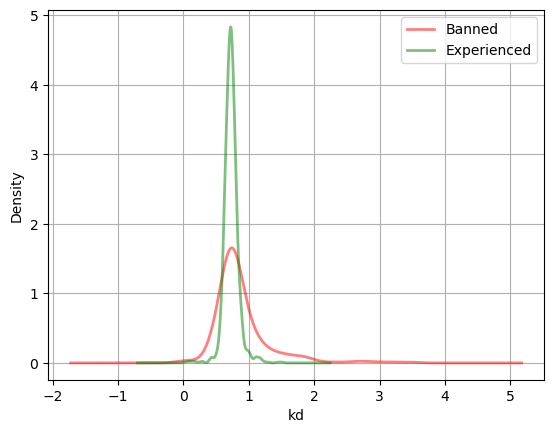

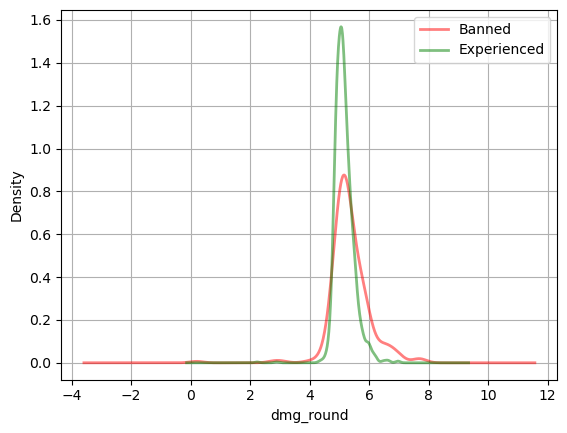

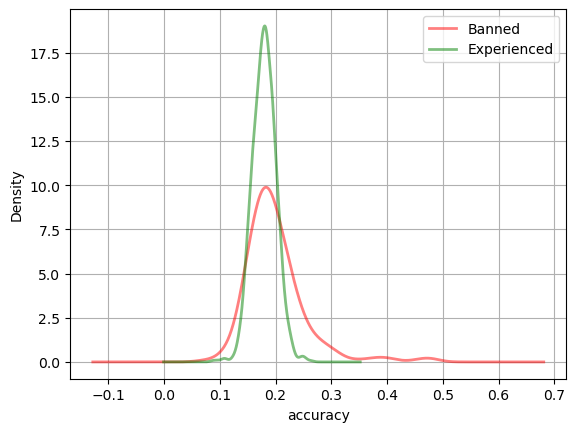

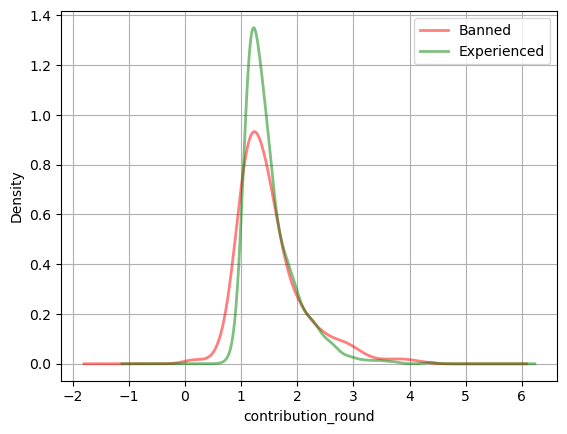

In [6]:
n_df_banned = n_df[n_df["banned"]==1]
n_df_experienced = n_df[n_df["banned"]==0]

for feature in n_df_banned.columns[:-1]:
    plt.figure()
    n_df_banned[feature].plot(kind="density", color="red", linewidth=2, alpha=0.5, label="Banned", grid=True)
    n_df_experienced[feature].plot(kind="density", color="green", linewidth=2, alpha=0.5, label="Experienced",grid=True)
   
    plt.xlabel(feature)
    plt.legend()
    plt.show()

In [7]:
n_df.head()

,win_%,hs_%,mvp_%,kd,dmg_round,accuracy,contribution_round,banned
0,0.414515,0.628620,0.062670,2.690986,7.072966,0.311167,2.001884,1
1,0.693147,0.617435,0.330854,1.730799,6.034965,0.182698,1.839615,1
2,0.406423,0.586494,0.113519,1.509081,5.805775,0.246237,0.902567,0
3,0.693147,0.578737,0.246860,1.155771,6.509842,0.397244,1.313724,1
4,0.393833,0.575161,0.145620,2.658333,6.299520,0.241565,1.170644,1


# 3. Model Selection, Training and Evaluation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Splitting the data
X = n_df.drop("banned", axis=1)
y = n_df["banned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting Logreg
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Test
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probability of class 1 (Banned)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       287
           1       1.00      0.14      0.24        36

    accuracy                           0.90       323
   macro avg       0.95      0.57      0.60       323
weighted avg       0.91      0.90      0.87       323

Confusion Matrix:
[[287   0]
 [ 31   5]]
ROC AUC Score:
0.6726674409601239


In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Resample & Split
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1] 

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       285
           1       0.88      0.90      0.89       253

    accuracy                           0.89       538
   macro avg       0.89      0.89      0.89       538
weighted avg       0.89      0.89      0.89       538

Confusion Matrix:
[[253  32]
 [ 26 227]]
ROC AUC Score:
0.9444143956729769
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       285
           1       0.67      0.57      0.62       253

    accuracy                           0.67       538
   macro avg       0.67      0.66      0.66       538
weighted avg       0.67      0.67      0.66       538

Confusion Matrix:
[[214  71]
 [109 144]]
ROC AUC Score:
0.6868039664378338


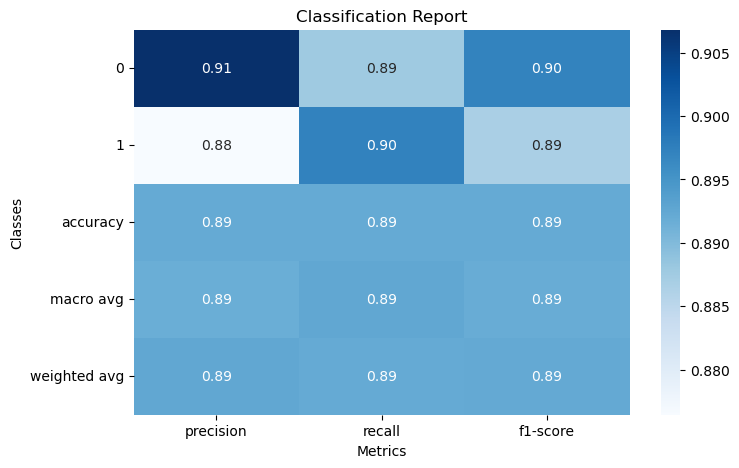

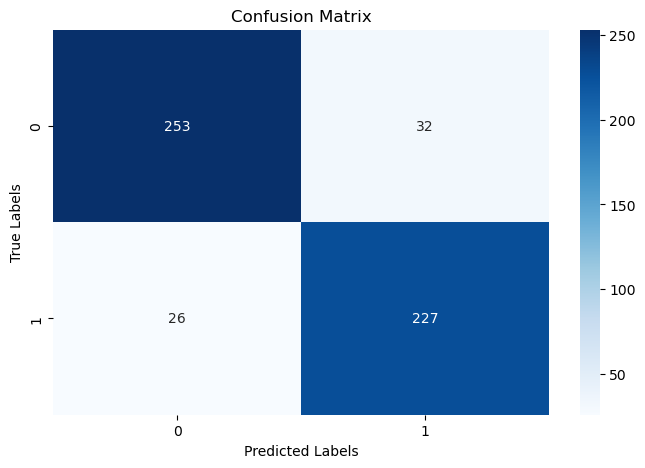

In [10]:
# Chosen algorithm: Random Forest
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
rf_cr = classification_report(y_test, y_pred,output_dict=True)
rf_cm = confusion_matrix(y_test, y_pred)
rf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the classification report
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(pd.DataFrame(rf_cr).iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f", ax=ax)
ax.set_title('Classification Report')
ax.set_xlabel('Metrics')
ax.set_ylabel('Classes')
plt.show()

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(rf_cm, annot=True, cmap="Blues", fmt="d", ax=ax)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [ ]:
from joblib import dump

dump(rf_classifier, 'cheater_proba_rf_classifier.joblib')